##  **Case Study Assumptions**

Bellabeat is a high-tech manufacturer of health-focused products for women. The company would like to explore new growth opportunities and has requested a data analysis of smart device fitness data that would potentially guide its new marketing strategy. 

#### **To analyze**

 1. What are some trends in small device usage?
 2. How could these trends apply to Bellabeat customers?
 3. How could these trends help influence Bellabeat marketing strategy?

## **Loading packages**

In [1]:
library(tidyverse)
library(lubridate)
library(dplyr)
library(ggplot2)
library(tidyr)
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor




## **Importing data**

Data used for this analysis is [FitBit Fitness Tracker Data](https://www.kaggle.com/datasets/arashnic/fitbit)

I have first checked the csv files in Google Sheets to understand what type of data is provided. I have then chose to work only on 4 files: hourly reports for steps, calories and intensities and the daily activity report. 

In [2]:
hourlyCalories <- read.csv("/kaggle/input/fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/hourlyCalories_merged.csv")
hourlyIntensities <- read.csv("/kaggle/input/fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv")
hourlySteps <- read.csv("/kaggle/input/fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv")
dailyActivity <- read.csv("/kaggle/input/fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")

## **Formatting issue**

Data in the Activity Hour column is provided in different formats. In order to continue with the analysis, this has to be unified. 

In [3]:
library(lubridate)

hourlySteps$ActivityHour <- mdy_hms(hourlySteps$ActivityHour)
hourlyCalories$ActivityHour <- mdy_hms(hourlyCalories$ActivityHour)
hourlyIntensities$ActivityHour <- mdy_hms(hourlyIntensities$ActivityHour)
dailyActivity$ActivityDate <- mdy(dailyActivity$ActivityDate)

## **Combining Data from Hourly reports**

In order to faciliate further analysis for myself I decided to combine the data from 3 hourly reports into 1.

I plan to analyze the data by hours of the day and days of the week to see if there are any patterns in the data usage. For that I create new colums with:
* the activity hour
* date only
* names of week days
* type of days (regular or weekend)

In [4]:
combined_data <- hourlyCalories %>% 
  left_join(hourlyIntensities, by = c("Id", "ActivityHour")) %>% 
  left_join(hourlySteps, by = c("Id", "ActivityHour"))

combined_data$Hour <- format(combined_data$ActivityHour, "%H")
combined_data$Day <- as.Date(combined_data$ActivityHour)

combined_data <- combined_data %>% 
  mutate(Weekday = wday(Day, label=TRUE, week_start = 1))

combined_data <- combined_data %>% 
  mutate(DayType =ifelse(Weekday %in% c("Mon", "Tue", "Wed", "Thu", "Fri"), 
                         "Weekday", 
                         "Weekend")) 

I will first check the relation between the step count and activity intensity to see if it is only the steps that cause higher intensity. 

#### **My conclusions for the business:**
* vast majority of activity remains in the low intensity level and within the range 2500 steps >> if an app registers data in that frame for 3 conscutive days it could send encouragement notification to have a walk or increase intensity by other type of training
* there is a interesting group having high intensity time while keeping the step count under 2500 >> my assumption is that users in that frame prefer other types of activity than walking/running, they could be encouraged to have a walk outside and get some fresh air on top of their other training


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


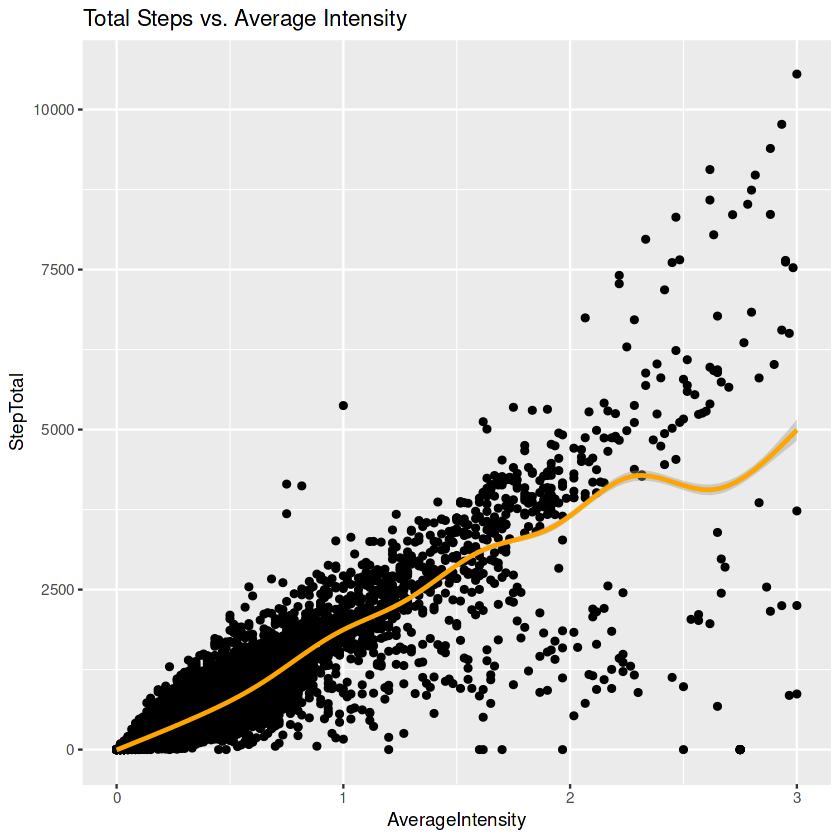

In [5]:
ggplot(data=combined_data, aes(x=AverageIntensity, y=StepTotal)) + 
    geom_point(colour="black") + 
    geom_smooth(colour="orange") + 
    labs(title="Total Steps vs. Average Intensity")

## **Analysis per time of day**

I now move on to combining the data on intensity, calories and steps by the time of day. 
I then create 2 graphs showing how average intensity and step count changes over the course of day. As expected they both show quite similar flow. 

#### **My conclusions for the business are:**
* There is potential to encourage the users to have a walk or a training in early morning between 6-7 and late evening between 20-22. A notification could be sent after 20:00 to have a short walk before going to bed informing on good influnce of fresh air on good night sleep. 

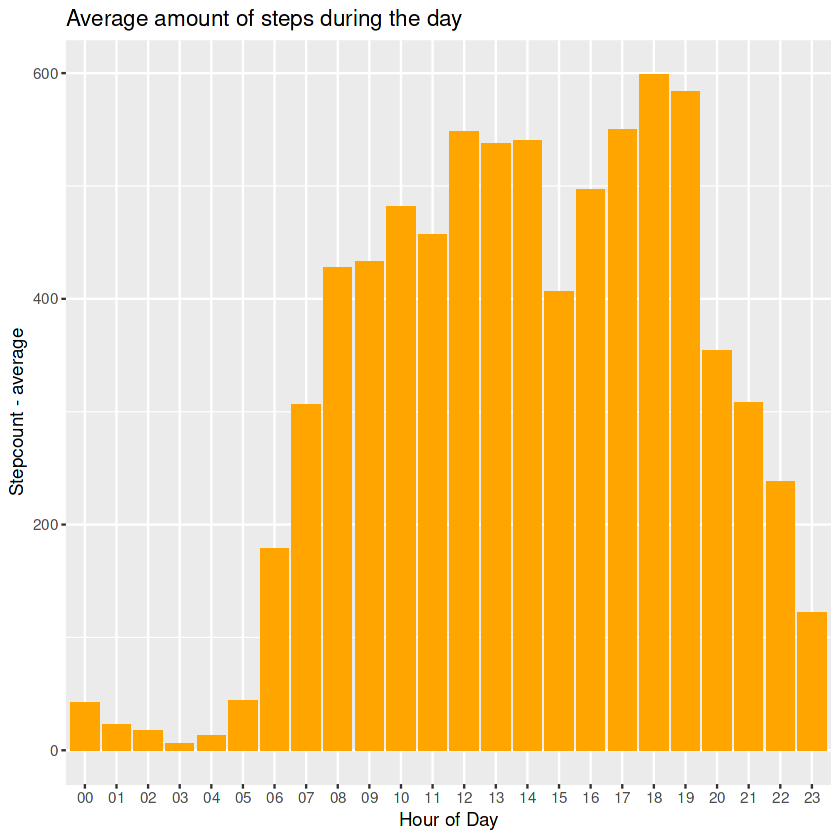

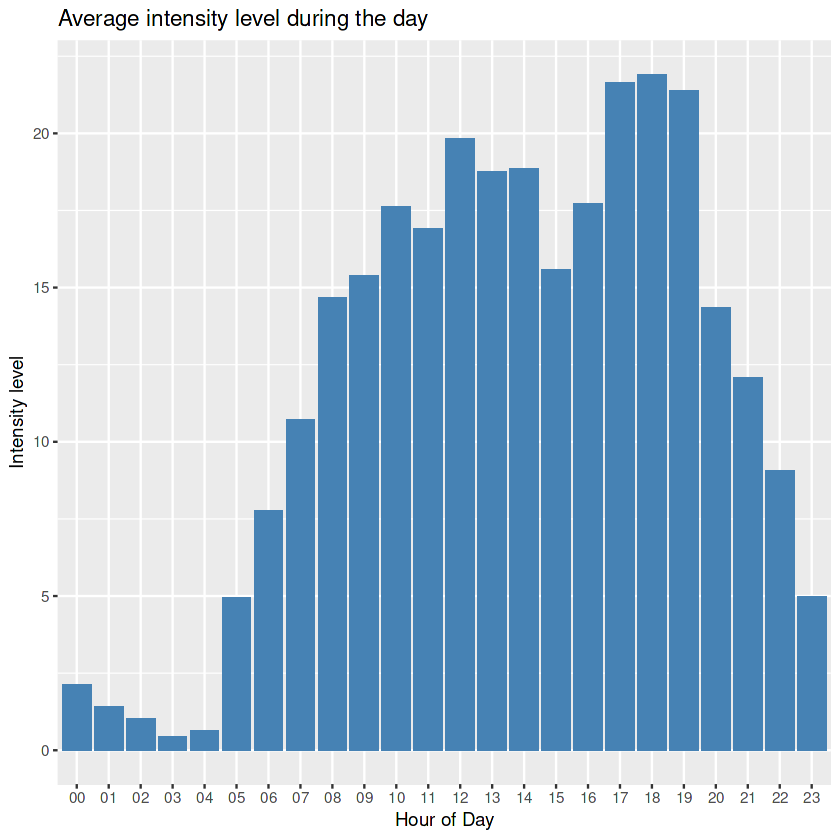

In [6]:
## grouping data by hour of the day

combined_data_by_hour <- combined_data %>% 
  select(Hour, Calories,TotalIntensity,StepTotal) %>% 
  rename(Intensity = TotalIntensity) %>% 
  rename(Steps = StepTotal) %>% 
  group_by(Hour) %>% 
  summarize(
    total_calories = sum(Calories),
    avg_calories = mean(Calories),
    total_steps = sum(Steps),
    avg_steps = mean(Steps),
    avg_intesity = mean(Intensity)
  )

## and the charts

ggplot(data=combined_data_by_hour) + 
    geom_col(mapping=aes(x=Hour, y=avg_steps), fill="orange") +
    labs(title="Average amount of steps during the day", x="Hour of Day", y="Stepcount - average")

ggplot(data=combined_data_by_hour) + 
    geom_col(mapping=aes(x=Hour, y=avg_intesity), fill="steelblue") +
    labs(title="Average intensity level during the day", x="Hour of Day", y="Intensity level")

## **Analysis per weekdays**

Next idea for analysis is to check intensity, calories and steps by the weekday. I am preparing 2 graphs ilustrating how many steps each user takes on each day of the week and then a summary chart showing average stepcount per day of the week. 

#### **My conclusions for the business are:**
* The least active working days are Monday and Friday. Encouragement messages can be sent during those days like ie. "Kick that Monday in the butt and hit the gym!", "Have that power walk just now to get energized for the weekend!".
* The step count drops on Sunday and since it is usually a day off, users can be motivated for additional activity.
* Some users do hit higher stepcounts, but many do not exceed the 5k steps. These users should be motivated to increase the daily limit to first 7500 and 10000 steps in order to mainatain good health.

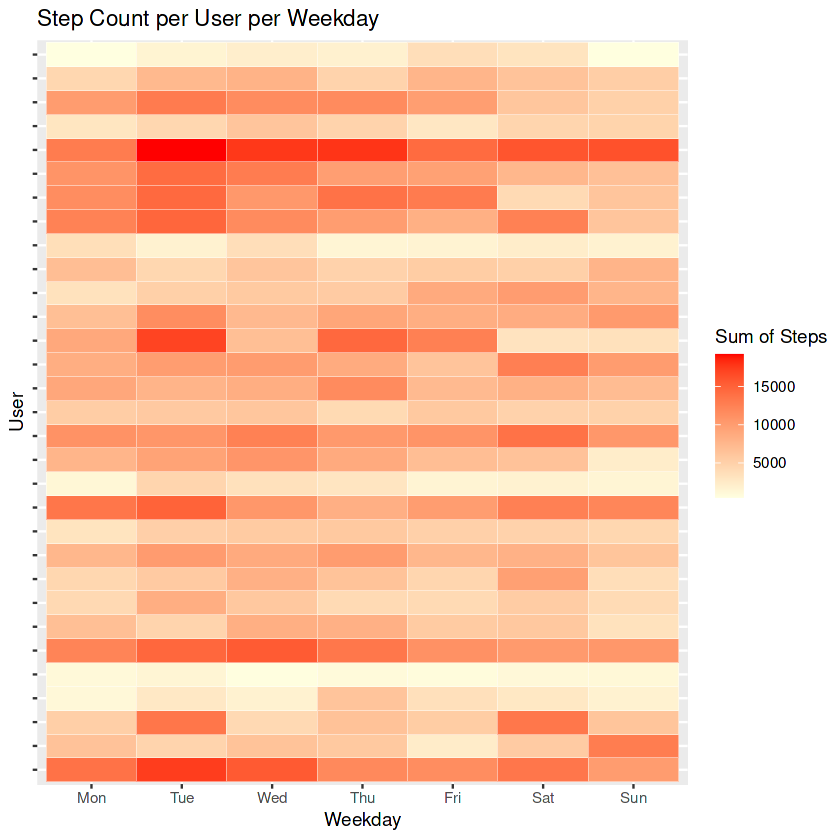

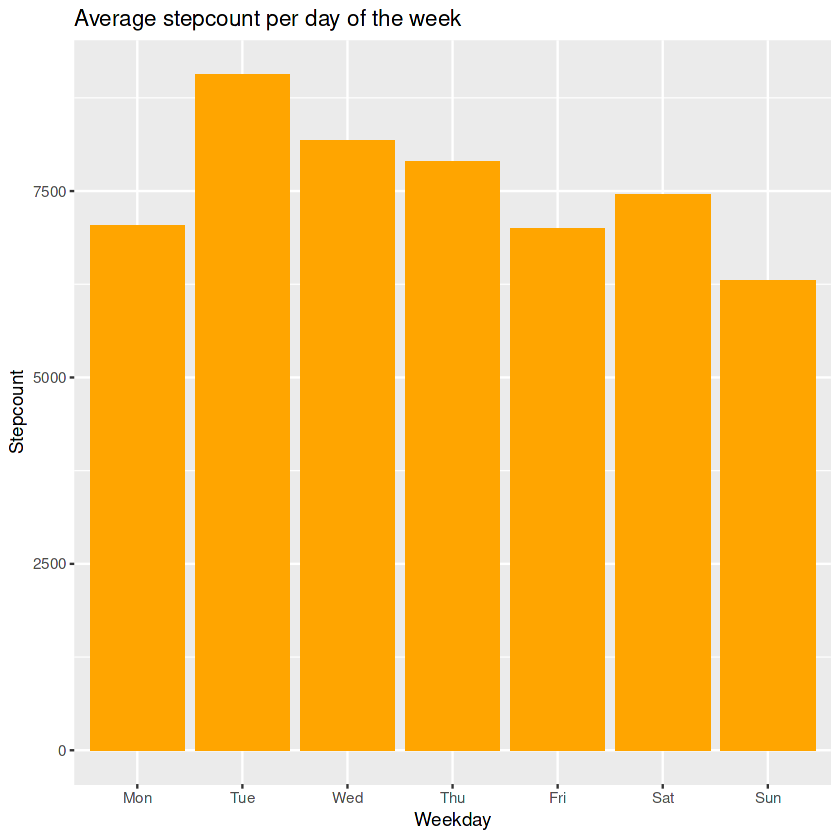

In [7]:
week_check <- combined_data %>% 
    select(Id, StepTotal, Weekday) %>% 
    filter (Id != 8877689391 & Id != 4057192912) %>%  
    group_by(Id, Weekday) %>% 
    summarize(Steps = sum(StepTotal)/4, .groups = "drop") %>% 
    ungroup()

## heatmap
## userIDs are hidden for data privacy reasons

ggplot(week_check, aes(x = Weekday, y = factor(Id), fill = Steps)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightyellow", high = "red") +
  labs(title = "Step Count per User per Weekday",
       x = "Weekday", y = "User", fill = "Sum of Steps") +
  theme(axis.text.y = element_blank())


## second chart for average stepcount

week_check2 <- week_check %>% 
    group_by(Weekday) %>% 
    summarize(avg_steps_per_weekday = round(mean(Steps)))

ggplot(data=week_check2) + 
    geom_col(mapping=aes(x=Weekday, y=avg_steps_per_weekday), fill="orange") +
    labs(title="Average stepcount per day of the week", x="Weekday", y="Stepcount")



## Calories vs. Intensity

The last check from this combined file is the correlation between burnt calories and activity's intensity. As expected, the higher intensity, the more calories are burnt. What was a little surprising was to discover that 93% of all the calories burnt by users within the given time frame were burnt in the low intensity range. 

#### **My conclusions for the business are:**
* Users could be encouraged to take on higher intensity activities if they are interested in burning more calories.

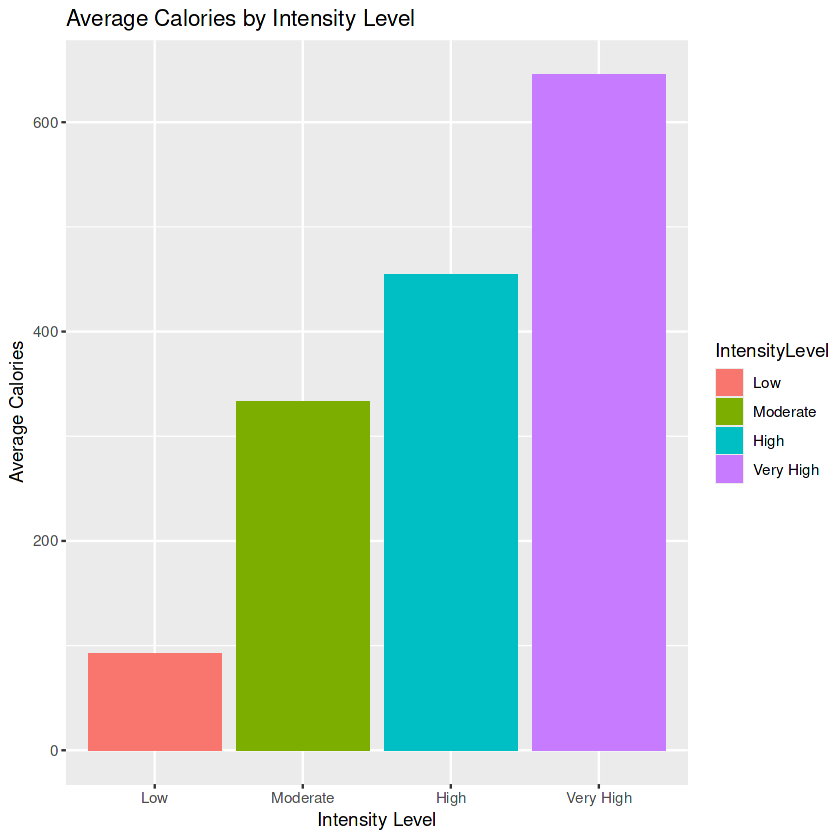

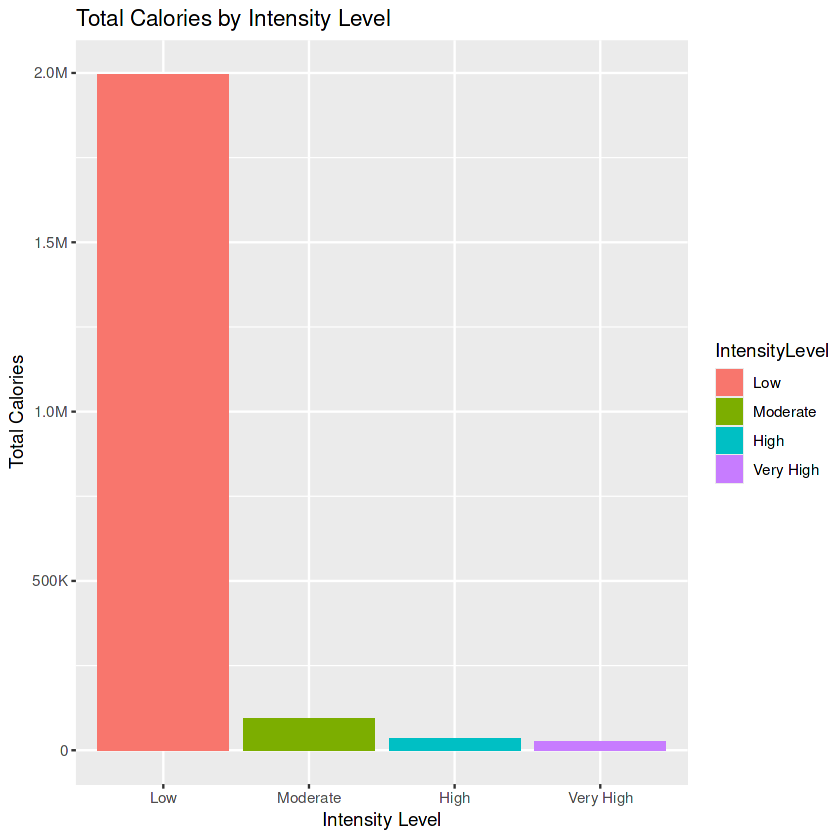

In [8]:
## Average calories

combined_data %>%
  mutate(IntensityLevel = cut(TotalIntensity, 
                  breaks = c(0, 90, 130, 160, 200), 
                  labels = c("Low", "Moderate", "High", "Very High"), 
                  include.lowest = TRUE 
                  )) %>% 
  group_by(IntensityLevel) %>% 
  summarize(avg_calories = mean(Calories, na.rm = TRUE)) %>% 
  ggplot(aes(x = IntensityLevel, y = avg_calories, fill = IntensityLevel)) + 
  geom_col() + 
  scale_y_continuous(labels = label_number(scale_cut = cut_short_scale())) +
  labs( 
    title = "Average Calories by Intensity Level", 
    x = "Intensity Level", 
    y = "Average Calories" )


## Total calories

combined_data %>%
  mutate(IntensityLevel = cut(TotalIntensity, 
                  breaks = c(0, 90, 130, 160, 200), 
                  labels = c("Low", "Moderate", "High", "Very High"), 
                  include.lowest = TRUE 
                  )) %>% 
  group_by(IntensityLevel) %>% 
  summarize(sum_calories = sum(Calories, na.rm = TRUE)) %>% 
  ggplot(aes(x = IntensityLevel, y = sum_calories, fill = IntensityLevel)) + 
  geom_col() + 
  scale_y_continuous(labels = label_number(scale_cut = cut_short_scale())) +
  labs( 
    title = "Total Calories by Intensity Level", 
    x = "Intensity Level", 
    y = "Total Calories" )




## **Daily Activities Analysis**

Next I move on to the Daily Activity dataset. After the last conclusions I decide to check the levels of activity now that the dataset provides the division into sedentary, lightly, fairly and very active levels. The analysis shows that the users spend 68,8% time in seating position.  

#### **My conclusions for the business are:**
* Remind people to make breaks during longer sedentary periods. Reminders such as: "Time to move! You've been sitting for 2 hours" could potentially encourage users to have a 10-15 min walk break. Also reiterate on the importance and value of even short activity periods.








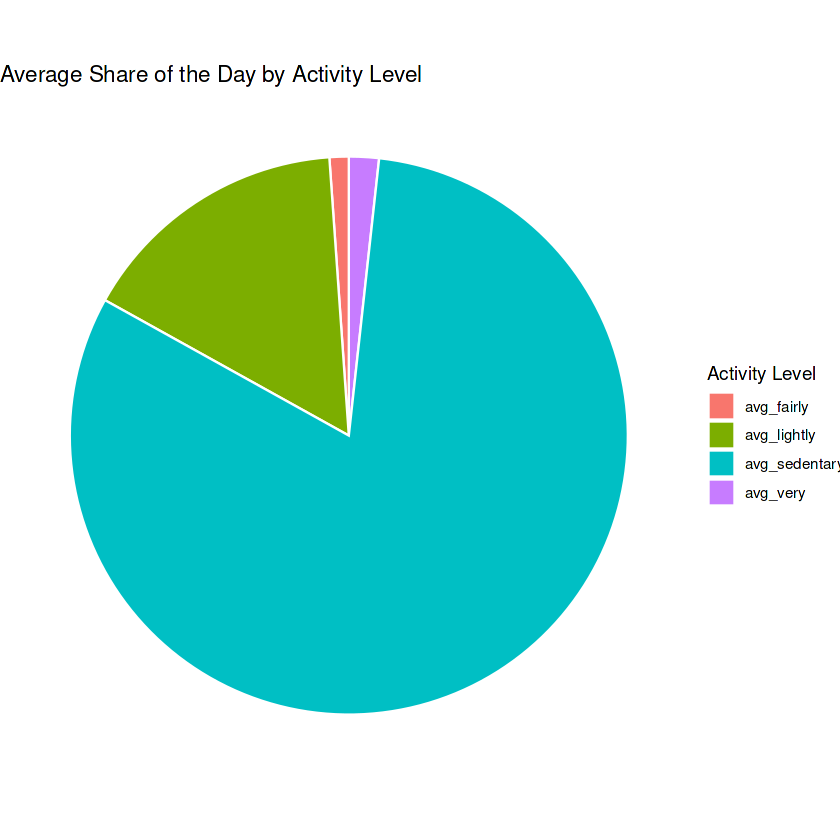

In [9]:
active_minutes <- dailyActivity %>% 
  summarize(
    avg_very = mean(VeryActiveMinutes),
    avg_fairly = mean(FairlyActiveMinutes),
    avg_lightly = mean(LightlyActiveMinutes),
    avg_sedentary = mean(SedentaryMinutes)
  ) %>% 
  mutate(
    avg_very = avg_very / 1440 * 100,
    avg_fairly = avg_fairly / 1440 * 100,
    avg_lightly = avg_lightly / 1440 * 100,
    avg_sedentary = avg_sedentary / 1440 * 100
  )

## transfor to long data

active_minutes_long <- active_minutes %>%
  tidyr::pivot_longer(cols = everything(),
                      names_to = "ActivityLevel",
                      values_to = "PercentOfDay")

## chart

ggplot(active_minutes_long, aes(x = "", y = PercentOfDay, fill = ActivityLevel)) +
  geom_col(width = 1, color = "white") +
  coord_polar(theta = "y") +
  labs(title = "Average Share of the Day by Activity Level",
       fill = "Activity Level") +
  theme_void()



The last analysis I want to make is to check teh relation between Very Active Minutes and Calories Burnt. The result are as expectd - the more very active time, the more calories are burnt. Spending more than 50 minutes on very intense training can significantly increase the calory burn. 

* For users focused on calorie deficit - inform about HIIT training, increasing their activity intensity even for a short while to increase the calorie burn,

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


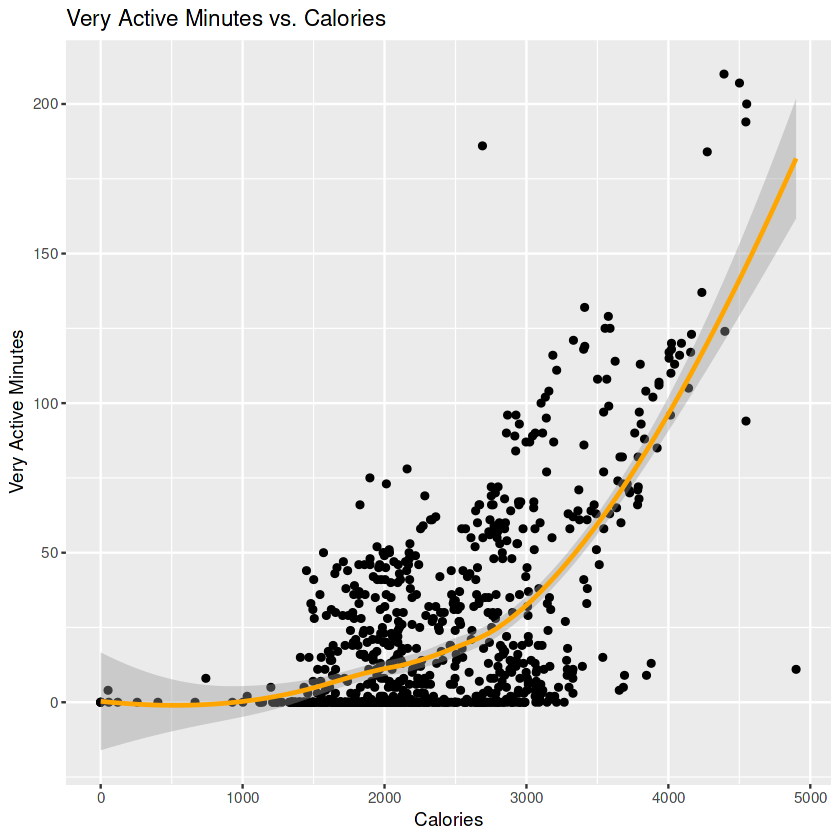

In [10]:
## very active time. vs. calorie


ggplot(data=dailyActivity, aes(x=Calories, y=VeryActiveMinutes)) + 
  geom_point(colour="black") + 
  geom_smooth(colour="orange") + 
  labs(title="Very Active Minutes vs. Calories",
      y="Very Active Minutes")

## Summary


#### To analyze

1. What are some trends in small device usage?
2. How could these trends apply to Bellabeat customers?
3. How could these trends help influence Bellabeat marketing strategy?


The analysis show that not many users are engaged in using their small devices to support, enhance or improve their daily activities. The group of users analyzed spend majority of their time in sedentary position and rarely take up high effort activities.
Based on this analysis my suggestion would be to create a more interactive application which, in connection to the measures it gathers, communicates with the user and remind them of healthy habits. An idea would also be to incorporate some daily small tasks or challenges. For users who are not used to be active it is important to start small and appreciate the value of these small changes.






*Disclaimer: This is my first analysis done in Kaggle and R language. Any suggestion on how to improve are welcome. Thank you!*
